https://manual.nexusformat.org/classes/base_classes/index.html#base-class-definitions

In [1]:
%pylab notebook

import h5py
import numpy as np

import sidpy

import sys
sys.path.insert(0, '../../')
import datetime
import pyNSID

Populating the interactive namespace from numpy and matplotlib


## Make sidpy dataset

In [2]:
dataset = sidpy.Dataset.from_array(np.random.random([4, 5]), name='new')

dataset.data_type = 'IMAGE'
dataset.units = 'nA'
dataset.quantity = 'Current'
dataset.title = 'random'

dataset.set_dimension(0, sidpy.Dimension(np.arange(dataset.shape[0]), 'x',
                                        units='nm', quantity='Length',
                                        dimension_type='spatial'))
dataset.set_dimension(1, sidpy.Dimension(np.linspace(-2, 2, num=dataset.shape[1], endpoint=True), 'y', 
                                        units='nm', quantity='Length',
                                        dimension_type='spatial'))


## Write pyNSID file normally

In [4]:
file_name = "test2.hf5"

h5_file = h5py.File(file_name, 'a')

if 'Measurement_000' in h5_file:
    h5_group = sidpy.hdf.prov_utils.create_indexed_group(h5_group, 'Measurement_')
else:
    h5_group = h5_file.create_group('Measurement_000')

if 'Channel_000' in h5_group:
    h5_group = sidpy.hdf.prov_utils.create_indexed_group(h5_group, 'Channel_')
else:
    h5_group = h5_group.create_group('Channel_000')

dataset.h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dataset, h5_group)


../..\pyNSID\io\hdf_utils.py:352: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


## Make NeXus format compatible

In [29]:
def make_nexus_compatible(h5_dataset):
    
    time_stamp = "T".join( str( datetime.datetime.now() ).split() )
    h5_file = h5_dataset.file
    h5_group = h5_dataset.parent.parent
    h5_file.attrs[u'default']  = h5_dataset.parent.parent.name

    # give the HDF5 root some more attributes

    h5_file.attrs[u'file_name'] = h5_file.filename
    h5_file.attrs[u'file_time'] = time_stamp
    h5_file.attrs[u'instrument'] = u'None'
    h5_file.attrs[u'creator'] = u'pyNSID'
    h5_file.attrs[u'NeXus_version'] = u'4.3.0'
    h5_file.attrs[u'HDF5_Version'] = h5py.version.hdf5_version
    h5_file.attrs[u'h5py_version'] = h5py.version.version

    h5_file.attrs[u'default']  = h5_group.name

    h5_group.attrs[u'NX_class'] = u'NXentry'
    h5_group.attrs[u'default'] = h5_dataset.name.split('/')[-1]

    if 'title' in h5_group:
        del h5_group['title']
    h5_group.create_dataset(u'title', data=h5_dataset.name.split('/')[-1])
    
    nxdata = h5_dataset.parent

    nxdata.attrs[u'NX_class'] = u'NXdata'
    nxdata.attrs[u'signal'] = h5_dataset.name.split('/')[-1]     # Y axis of default plot

    axes = []
    for dimension_label in h5_dataset.attrs['DIMENSION_LABELS']:
        axes.append(dimension_label.decode('utf8'))
    
    nxdata.attrs[u'axes'] = axes        # X axis of default plot
    for i, axis in enumerate(axes):
        nxdata.attrs[axes[i]+'_indices'] = [i,]   
    
# pyNSID.hdf_utils.make_nexus_compatible(dataset.h5_dataset)
make_nexus_compatible(dataset.h5_dataset)


In [26]:
print(dataset.h5_dataset.attrs['DIMENSION_LABELS'])
print(dict(dataset.h5_dataset.parent['_axes'].attrs))

[b'x' b'y']
{'0': array([0., 1., 2., 3.]), '1': array([-2., -1.,  0.,  1.,  2.])}


In [30]:
h5_file.close()

## Read with nexusformat

In [31]:
from nexusformat import nexus
nexus_dataset = nexus.nxload(file_name)

print(nexus_dataset.tree)

root:NXroot
  @HDF5_Version = '1.10.4'
  @NeXus_version = '4.3.0'
  @creator = 'pyNSID'
  @default = '/Measurement_000/Channel_000'
  @file_name = 'test2.hf5'
  @file_time = '2021-08-20T19:12:32.483537'
  @h5py_version = '2.10.0'
  @instrument = 'None'
  Measurement_000:NXgroup
    Channel_000:NXentry
      @default = 'random'
      random:NXdata
        @axes = ['x', 'y']
        @machine_id = 'DESKTOP-UM3713R'
        @platform = 'Windows-10-10.0.19041-SP0'
        @pyNSID_version = '0.0.2'
        @sidpy_version = '0.0.5'
        @signal = 'random'
        @timestamp = '2021_08_20-18_59_19'
        @x_indices = 0
        @y_indices = 1
        __dict__:NXgroup
          @_axes-0 = [0. 1. 2. 3.]
          @_axes-1 = [-2. -1.  0.  1.  2.]
          @_data_type = 'IMAGE'
          @_modality = 'generic'
          @_quantity = 'Current'
          @_source = 'generic'
          @_title = 'random'
          @_units = 'nA'
          @a = [0. 1. 2. 3.]
          @b = [0. 1. 2. 3. 4.]
      

<IPython.core.display.Javascript object>


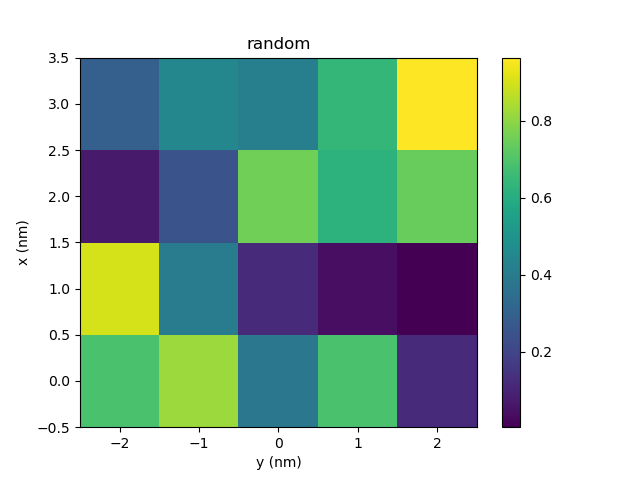

In [32]:
nexus_dataset.plot()

In [71]:
a[a.default]

NeXusError: Invalid index

In [31]:
root = h5py.File('NXarpes.h5', 'w')

# Create the GROUPS 
 
root.create_group('entry')
root['/entry'].attrs['NX_class'] = 'NXentry'
root['/entry'].attrs['EX_required'] = 'true'

In [37]:
# Create the FIELDS 
 
root['/entry'].create_dataset(name='title', data='SAMPLE-CHAR-DATA', maxshape=None)
root['/entry/title'].attrs['type'] = 'NX_CHAR'
root['/entry/title'].attrs['EX_required'] = 'true'

In [38]:
sidpy.hdf.hdf_utils.print_tree(root)

/
├ entry
  -----
  ├ title


In [29]:
def find_NXgroup(h5_group):
    """
    Uses visit() to find all groups with NX_class attribute

    Parameters
    ----------
    h5_group : :class:`h5py.Group`
        Group to search within for the Dataset

    Returns
    -------
    groups : list
        List of [object] corresponding to groups with attribute NX_class.

    """
    if not isinstance(h5_group, (h5py.File, h5py.Group)):
        raise TypeError('h5_group should be a h5py.File or h5py.Group object')

    # print 'Finding all instances of', ds_name
    groups = []

    def __find_name(name, obj):
        if  isinstance(obj, h5py.Group):
            found_nexus_group = False
            for key in dict(obj.attrs).keys():
                if 'NX_class' in key: 
                    found_nexus_group = True
            if found_nexus_group:
                groups.append(obj)
        return

    h5_group.visititems(__find_name)

    return groups

def find_nexus_class(groups, key):
    nexus_class =  None
    for group in groups:
        if  dict(group.attrs)['NX_class'].decode('UTF-8') == key:
            nexus_class = group
            
    return nexus_class

 

In [34]:
timestamp = "T".join(str( datetime.datetime.now() ).split())
timestamp

'2021-08-20T16:14:43.596847'

<HDF5 dataset "I0": shape (11, 11), type "<f8">
[56.9965 57.009  57.0185 57.028  57.037  57.047  57.057  57.0675 57.0785
 57.0905 57.095 ]
{'spec_name': b'eta'}
[90.9    90.9105 90.921  90.9305 90.9405 90.951  90.961  90.9705 90.981
 90.991  91.    ]
{'spec_name': b'chi'}
/S22/data
[0]
{'NX_class': b'NXdata', 'axes': array([b'eta', b'chi'], dtype='|S3'), 'chi_indices': array([0]), 'description': b'SPEC scan data', 'eta_indices': array([0]), 'signal': b'I0'}


<IPython.core.display.Javascript object>


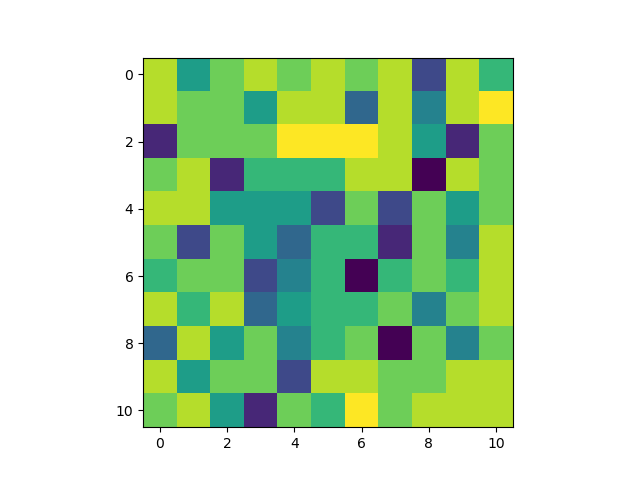

In [32]:

def read_nexus(file_name):
    file = h5py.File(file_name,'r')
    groups = find_NXgroup(file)

    if find_nexus_class(groups, 'NXentry') is None:
        print('This is not a NeXus file system')
    
    data_group = find_nexus_class(groups, 'NXdata')
    data_dict = dict(data_group.attrs)
    if 'signal' in data_dict:
        signal = data_dict['signal']
        if isinstance(signal, np.bytes_):
            signal = signal.decode('UTF-8')
        print(data_group[data_dict['signal']])
        data = data_group[data_dict['signal']][()]
    if 'axes' in data_dict:
        for axis in data_dict['axes']:
            if isinstance(axis, np.bytes_):
                axis = axis.decode('UTF-8')
            print(data_group[axis][()])
            print(dict(data_group[axis].attrs))

    dataset = sidpy.Dataset.from_array(data)
    
    for i, 
    dataset.set_dimension(0, sidpy.Dimension(np.arange(dataset.shape[0]), 'x',
                                        units='nm', quantity='Length',
                                        dimension_type='spatial'))
dataset.set_dimension(1, sidpy.Dimension(np.linspace(-2, 2, num=dataset.shape[1], endpoint=True), 'y', 
                                        units='nm', quantity='Length',
                                        dimension_type='spatial'))
dataset.set_dimension(2, sidpy.Dimension(np.sin(np.linspace(0, 2 * np.pi, num=dataset.shape[2])), 'bias',
                                        units='mV', quantity='Voltage',
                                        dimension_type='spectral'))
    
    
    return dataset



dataset = read_nexus('example_data/33id_spec_22_2D.hdf5')
    
print(data_group.name)
print(data_dict['chi_indices'])
print(data_dict)
plt.figure()
plt.imshow(dataset)

In [134]:
for key in data_group:
    print(key, ( data_group[key]))

Epoch <HDF5 dataset "Epoch": shape (11, 11), type "<f8">
H <HDF5 dataset "H": shape (11, 11), type "<f8">
I0 <HDF5 dataset "I0": shape (11, 11), type "<f8">
I00 <HDF5 dataset "I00": shape (11, 11), type "<f8">
I0_1 <HDF5 dataset "I0_1": shape (11, 11), type "<f8">
K <HDF5 dataset "K": shape (11, 11), type "<f8">
Kalpha <HDF5 dataset "Kalpha": shape (11, 11), type "<f8">
L <HDF5 dataset "L": shape (11, 11), type "<f8">
_mca_ <HDF5 dataset "_mca_": shape (11, 11, 91), type "<f8">
_mca_channel_ <HDF5 dataset "_mca_channel_": shape (91,), type "<i4">
chi <HDF5 dataset "chi": shape (11,), type "<f8">
elastic <HDF5 dataset "elastic": shape (11, 11), type "<f8">
eta <HDF5 dataset "eta": shape (11,), type "<f8">
harmonic <HDF5 dataset "harmonic": shape (11, 11), type "<f8">
seconds <HDF5 dataset "seconds": shape (11, 11), type "<f8">
signal <HDF5 dataset "signal": shape (11, 11), type "<f8">
signal2 <HDF5 dataset "signal2": shape (11, 11), type "<f8">


In [78]:
print(file, dict(file.attrs).keys())

for group in groups:
    if  dict(group.attrs)['NX_class'] == 'NXentry':
        print ('--- found entry')

<HDF5 file "33id_spec_22_2D.hdf5" (mode r)> dict_keys(['HDF5_Version', 'SPEC_comments', 'SPEC_date', 'SPEC_epoch', 'SPEC_file', 'SPEC_num_headers', 'SPEC_user', 'default', 'h5py_version', 'numpy_version', 'spec2nexus_version'])
--- found entry
